#**I. Exploratory Data Analysis**

##**1.1. Collecting Data**

In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
import joblib
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [ ]:
url='https://drive.google.com/file/d/13mO1xPuFByiOFIc2mpaGZeZa4HwFSJr7/view?usp=drive_link'
url= 'https://drive.google.com/uc?id=' + url.split('/')[-2]
print(url)
df = pd.read_csv(url)
df.head()

https://drive.google.com/uc?id=13mO1xPuFByiOFIc2mpaGZeZa4HwFSJr7


,Customer_ID,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,Is_laundering
0,714534108,10:35:19 AM,10/7/2022,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,Normal_Cash_Deposits,0
1,714534108,10:35:20 AM,10/7/2022,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,Normal_Fan_Out,0
2,710793783,10:35:20 AM,10/7/2022,4253533793,2248766608,5411.31,UK pounds,UK pounds,UK,UK,Credit card,Normal_Fan_In,1
3,714534108,10:35:20 AM,10/7/2022,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,Normal_Small_Fan_Out,0
4,714534108,10:35:21 AM,10/7/2022,5376652437,9600420220,"11.895,00",UK pounds,UK pounds,UK,UK,ACH,Normal_Fan_In,0


##**1.2. Initial Inspection**

In [ ]:
df.shape

(10001, 13)

Có tổng cộng là 10001 số lượng quan sát và có 13 cột trong bộ dữ liệu.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Customer_ID             10001 non-null  int64 
 1   Time                    10001 non-null  object
 2   Date                    10001 non-null  object
 3   Sender_account          10001 non-null  int64 
 4   Receiver_account        10001 non-null  int64 
 5   Amount                  10001 non-null  object
 6   Payment_currency        10001 non-null  object
 7   Received_currency       10001 non-null  object
 8   Sender_bank_location    10001 non-null  object
 9   Receiver_bank_location  10001 non-null  object
 10  Payment_type            10001 non-null  object
 11  Laundering_type         10001 non-null  object
 12  Is_laundering           10001 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 1015.9+ KB


Bộ dữ liệu có 10001 quan sát, trong đó không có giá trị nào bị trống.
Trong số các cột được ghi nhận thì có 4 cột có kiểu dữ liệu là số nguyên là
Customer_ID, Sender_account, Receiver_account và Is_laundering, 9 cột còn lại có kiểu dữ liệu là chuỗi ký tự.

In [ ]:
def clean_and_convert_amount(x):
    try:
        x = x.replace("-", "").replace(".", "").replace(",", ".")
        return float(x)
    except ValueError:
        return x
def handle_noise(x):
    if x < 0:
        return -x
    return x

df['Amount'] = df['Amount'].apply(clean_and_convert_amount).apply(handle_noise)

df

,Customer_ID,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,Is_laundering
0,714534108,10:35:19 AM,10/7/2022,8724731955,2769355426,145915.0,UK pounds,UK pounds,UK,UK,Cash Deposit,Normal_Cash_Deposits,0
1,714534108,10:35:20 AM,10/7/2022,1491989064,8401255335,601964.0,UK pounds,Dirham,UK,UAE,Cross-border,Normal_Fan_Out,0
2,710793783,10:35:20 AM,10/7/2022,4253533793,2248766608,541131.0,UK pounds,UK pounds,UK,UK,Credit card,Normal_Fan_In,1
3,714534108,10:35:20 AM,10/7/2022,287305149,4404767002,1432844.0,UK pounds,UK pounds,UK,UK,Cheque,Normal_Small_Fan_Out,0
4,714534108,10:35:21 AM,10/7/2022,5376652437,9600420220,11895.0,UK pounds,UK pounds,UK,UK,ACH,Normal_Fan_In,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,714534108,4:54:44 PM,10/7/2022,9172459992,4770834194,2459.0,UK pounds,UK pounds,UK,UK,Cash Deposit,Normal_Cash_Deposits,0
9997,714534108,4:54:44 PM,10/7/2022,3294594971,8012186699,314778.0,UK pounds,UK pounds,UK,UK,Cheque,Normal_Group,0
9998,719318583,4:54:47 PM,10/7/2022,5623596789,9622304369,771524.0,UK pounds,UK pounds,UK,UK,Debit card,Normal_Small_Fan_Out,0
9999,710793783,4:54:52 PM,10/7/2022,546049908,6962144426,115737.0,UK pounds,UK pounds,UK,UK,Debit card,Normal_Small_Fan_Out,0


**Xử lý cột Amount bị noise**

In [ ]:
df = df.drop(['Customer_ID', 'Sender_account', 'Receiver_account'], axis=1)
df

,Time,Date,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,Is_laundering
0,10:35:19 AM,10/7/2022,145915.0,UK pounds,UK pounds,UK,UK,Cash Deposit,Normal_Cash_Deposits,0
1,10:35:20 AM,10/7/2022,601964.0,UK pounds,Dirham,UK,UAE,Cross-border,Normal_Fan_Out,0
2,10:35:20 AM,10/7/2022,541131.0,UK pounds,UK pounds,UK,UK,Credit card,Normal_Fan_In,1
3,10:35:20 AM,10/7/2022,1432844.0,UK pounds,UK pounds,UK,UK,Cheque,Normal_Small_Fan_Out,0
4,10:35:21 AM,10/7/2022,11895.0,UK pounds,UK pounds,UK,UK,ACH,Normal_Fan_In,0
...,...,...,...,...,...,...,...,...,...,...
9996,4:54:44 PM,10/7/2022,2459.0,UK pounds,UK pounds,UK,UK,Cash Deposit,Normal_Cash_Deposits,0
9997,4:54:44 PM,10/7/2022,314778.0,UK pounds,UK pounds,UK,UK,Cheque,Normal_Group,0
9998,4:54:47 PM,10/7/2022,771524.0,UK pounds,UK pounds,UK,UK,Debit card,Normal_Small_Fan_Out,0
9999,4:54:52 PM,10/7/2022,115737.0,UK pounds,UK pounds,UK,UK,Debit card,Normal_Small_Fan_Out,0


Loại bỏ 3 cột 'Customer_ID', 'Sender_account', 'Receiver_account' vì chúng có tính đặc trưng duy nhất, dễ gây overfitting.

In [ ]:
df.describe()

,Amount,Is_laundering
count,1.000100e+04,10001.00000
mean,9.854889e+05,0.00140
std,1.102711e+07,0.03739
min,1.200000e+02,0.00000
25%,1.675750e+05,0.00000
50%,5.856330e+05,0.00000
75%,1.089397e+06,0.00000
max,1.075327e+09,1.00000


In [ ]:
df.isnull().sum()

,0
Time,0
Date,0
Amount,0
Payment_currency,0
Received_currency,0
Sender_bank_location,0
Receiver_bank_location,0
Payment_type,0
Laundering_type,0
Is_laundering,0


Kết quả cho thấy dữ liệu không có giá trị nào bị khuyết.

In [ ]:
df.duplicated().sum()

0

Không có dòng nào bị trùng lặp

In [ ]:
transactions_per_payment_type = df['Payment_type'].value_counts()
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()
transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 Credit card        2069
 ACH                2046
 Debit card         2025
 Cheque             1989
 Cross-border       1042
 Cash Deposit        566
 Cash Withdrawal     264
 Name: count, dtype: int64,
 Payment_type
 Cash Deposit       2
 Cash Withdrawal    1
 Cheque             1
 Credit card        2
 Cross-border       5
 Debit card         3
 dtype: int64)

**Đếm số lượng giao dịch theo từng loại hình thanh toán**

Loại hình thanh toán *Credit card* có số lượng giao dịch lớn nhất là 2069 giao dịch, tiếp đến là *ACH* với 2046 giao dịch, *Debit card* có 2025 giao dịch, *Cheque* có 1989 giao dịch, *Cross-border* có tổng cộng là 1042 giao dịch, và cuối cùng là *Cash Deposit* và *Cash Withdrawal* với số giao dịch lần lượt là 566 và 264 giao dịch

**Đếm số lượng giao dịch rửa tiền theo loại thanh toán**

*Lọc ra các giao dịch có dấu hiệu rửa tiền (Cột 'Is_laundering' = 1 nếu giao dịch đó có dấu hiệu rửa tiền).*
*Sau đó, nhóm các giao dịch có dấu hiệu rửa tiền theo loại thanh toán;*
*Đếm số lượng giao dịch theo loại thanh toán.*

Loại giao dịch có dấu hiệu rửa tiền cao nhất là *Cross-border* với 5 giao dịch có dấu hiệu rửa tiền, *Debit card* có 3 giao dịch, *Credit card* và *Cash Deposit* có cùng số giao dịch có dấu hiệu rửa tiền là 2 giao dịch, và cuối cùng là *Cash Withdrawal* và *Cheque* có 1 giao dịch.

##**1.3. Class Distribution**

In [ ]:
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
laundering_stats = df[df['Is_laundering'] == 1]['Amount'].agg(['max', 'mean', 'min'])
normal_stats = df[df['Is_laundering'] == 0]['Amount'].agg(['max', 'mean', 'min'])
print("Laundering Transactions Stats:\n", laundering_stats)
print("\nNormal Transactions Stats:\n", normal_stats)

Laundering Transactions Stats:
 max     1.075327e+09
mean    7.736317e+07
min     1.060400e+04
Name: Amount, dtype: float64

Normal Transactions Stats:
 max     9.984536e+07
mean    8.784210e+05
min     1.200000e+02
Name: Amount, dtype: float64


*Chuyển đổi giá trị trong cột 'Amount' sang kiểu dữ liệu số học (numeric).
Việc này giúp đảm bảo cột 'Amount' có kiểu dữ liệu thống nhất là số, tránh lỗi khi thực hiện các phép tính thống kê sau này.*

Lọc ra các giao dịch có dấu hiệu rửa tiền (tức là cột 'Is_laundering' == 1).
Sau khi lọc, nó sẽ tính toán ba thống kê: max, mean, và min của cột 'Amount' cho các giao dịch có dấu hiệu rửa tiền.

Thực hiện tương tự đối với các giao dịch không có dấu hiệu rửa tiền (khi Is_laundering == 0).

In [ ]:
import seaborn as sns
total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')

combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot], how='outer')
combined_pivot = combined_pivot.fillna(0)

cm = sns.light_palette('#FE6F5E', as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm)

combined_pivot['Laundering_Count'] = combined_pivot['Laundering_Count'].map(lambda x: '{:.2f}'.format(x))

styled_combined_pivot

,Amount,Laundering_Count,Normal_Count
Payment_type,,,
ACH,1975740740.000000,0.00,2046
Cash Deposit,126128445.000000,2.00,564
Cash Withdrawal,3551159.000000,1.00,263
Cheque,1906896987.000000,1.00,1988
Credit card,1986822578.000000,2.00,2067
Cross-border,2153657152.000000,5.00,1037
Debit card,1703077801.000000,3.00,2022


**Tính tổng số tiền giao dịch và số lượng giao dịch theo từng loại thanh toán (Payment_type):**

Tính tổng số tiền (Amount) cho mỗi loại thanh toán.

Đếm số lượng giao dịch có dấu hiệu rửa tiền (Is_laundering = 1) và số lượng giao dịch bình thường (Is_laundering = 0) theo loại thanh toán.

Kết hợp các bảng thống kê trên thành một DataFrame duy nhất, điền giá trị NaN bằng 0

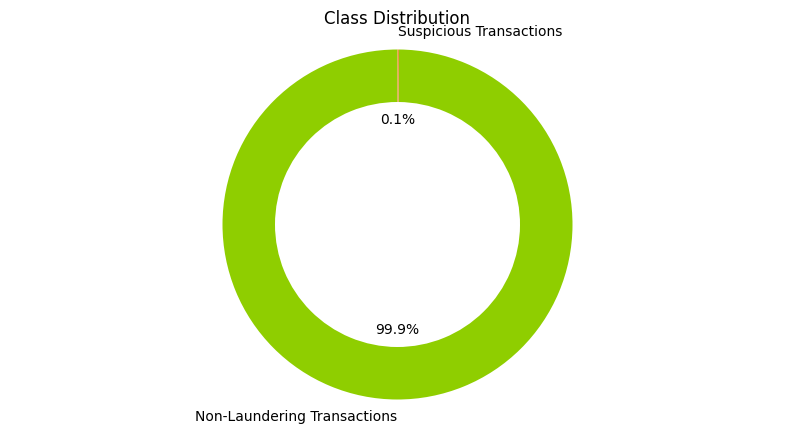

In [ ]:
import matplotlib.pyplot as plt

class_distribution = df['Is_laundering'].value_counts()

plt.figure(figsize=(10, 5))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'],
        autopct='%1.1f%%', colors=['#8fce00', '#ea963e'], startangle=90, wedgeprops=dict(width=0.3))

plt.title('Class Distribution')

plt.axis('equal')

plt.show()

> 99.9% các giao dịch là "Non-Laundering Transactions" (không có dấu hiệu rửa tiền). Chỉ có 0.1% các giao dịch là "Suspicious Transactions" (có dấu hiệu rửa tiền).
=> Tập dữ liệu mất cân bằng



##**1.4. Skewed Distribution**

Original Skewness: 92.76078849262875
Log-Transformed Skewness: -1.1541787136169532


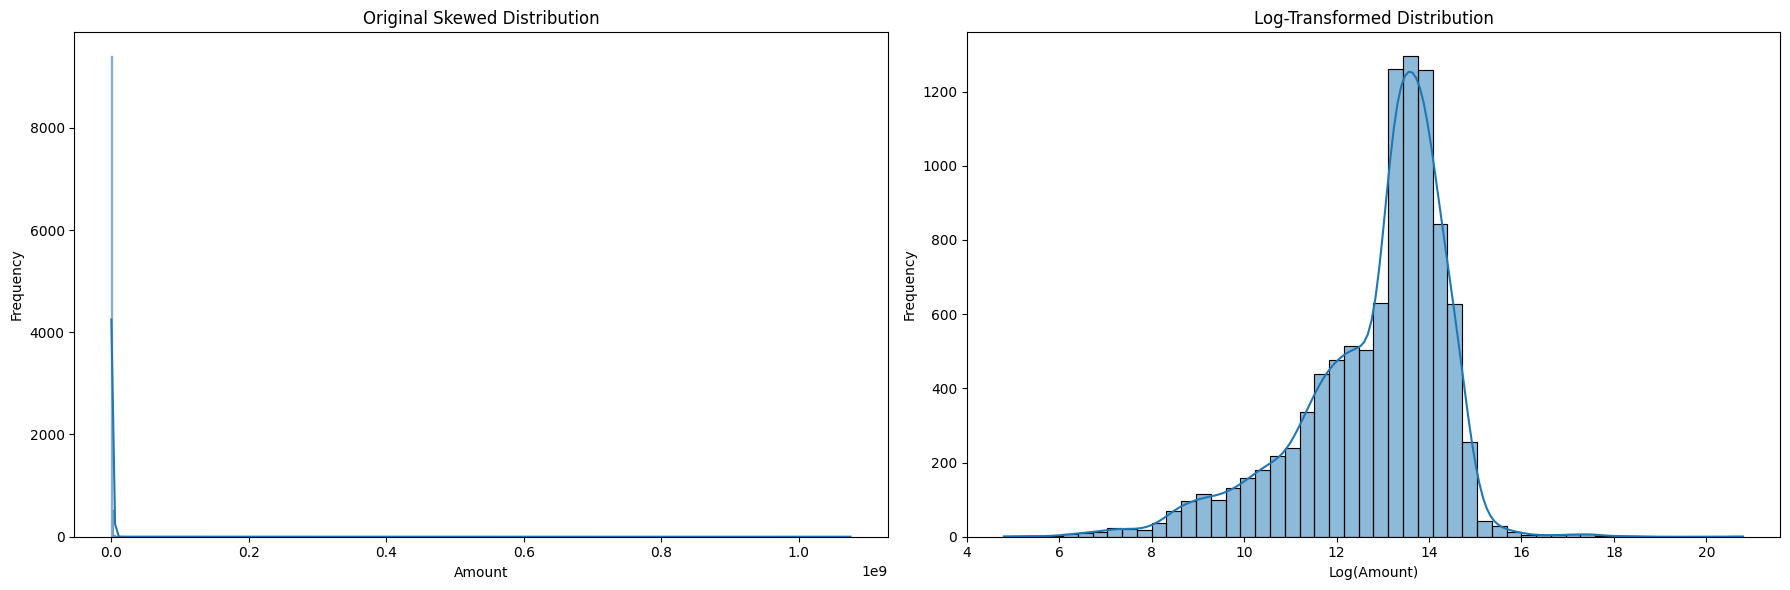

In [ ]:
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt

df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

df = df.dropna(subset=['Amount'])

skewed_data = df['Amount']

original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

positive_amounts = df[df['Amount'] > 0]['Amount']

log_transformed_data = np.log1p(positive_amounts)

transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(skewed_data, bins=500, kde=True, ax=ax[0])
ax[0].set_title('Original Skewed Distribution')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')

sns.histplot(log_transformed_data, bins=50, kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Distribution')
ax[1].set_xlabel('Log(Amount)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Xử lý dữ liệu trong cột 'Amount' và biến đổi dữ liệu này để làm giảm độ lệch (skewness) của phân phối**

- Chuyển đổi dữ liệu: Chuyển cột 'Amount' thành kiểu số và loại bỏ các giá trị không hợp lệ hoặc thiếu (NaN).

- Tính độ lệch ban đầu: Đo độ lệch (skewness) của phân phối dữ liệu trong cột 'Amount'.

- Loại bỏ giá trị âm: Giữ lại chỉ các giá trị dương trong cột 'Amount'.
Biến đổi log: Áp dụng biến đổi log (log1p) lên các giá trị dương để làm giảm độ lệch của dữ liệu.

- Tính độ lệch sau biến đổi: Tính lại độ lệch của phân phối sau khi áp dụng biến đổi log.

- Vẽ biểu đồ: Hiển thị hai biểu đồ histogram so sánh phân phối dữ liệu ban đầu và sau khi biến đổi log.

*Mục tiêu là làm giảm độ lệch của dữ liệu (đặc biệt khi phân phối lệch phải) để có được một phân phối gần với chuẩn hơn.*





**Nhận Xét:**

Ta thấy độ lệch ban đầu của dữ liệu là 92.76078849262875 => Dữ liệu bị lệch phải

Sau khi lấy log, thì độ lệch của dữ liệu còn -1.1541787136169532
=> Dữ liệu có phân phối gần phần phối chuẩn hơn.

##**1.5. Data Visualization**

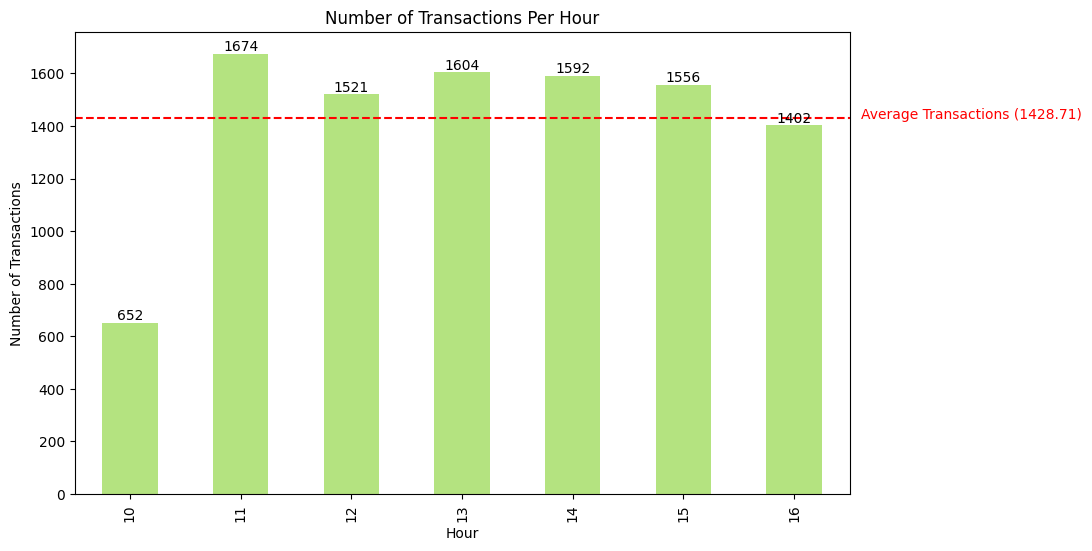

In [ ]:
import matplotlib.pyplot as plt

df['Time'] = pd.to_datetime(df['Time'])

hourly_transactions = df.groupby(df['Time'].dt.hour).size()

hourly_transactions.plot(kind='bar', figsize=(10, 6), color='#B4E380')

plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Hour')

for i in plt.gca().patches:
    plt.gca().text(i.get_x() + i.get_width() / 2, i.get_height() + 0.05, str(int(i.get_height())), ha='center', va='bottom')

average_hourly_transactions = hourly_transactions.mean()
plt.axhline(y=average_hourly_transactions, color='red', linestyle='--')

plt.text(8.6, average_hourly_transactions, f'Average Transactions ({average_hourly_transactions:.2f})', color='red', ha='right')

plt.show()

**Phân tích và trực quan hóa số lượng giao dịch theo từng giờ:**

- Chuyển đổi cột 'Time' thành định dạng datetime để có thể thao tác với thời gian.
- Tính số lượng giao dịch theo từng giờ bằng cách nhóm dữ liệu theo giờ và đếm số giao dịch trong mỗi nhóm.
- Vẽ biểu đồ cột hiển thị số lượng giao dịch mỗi giờ.
- Thêm số lượng giao dịch lên trên mỗi cột trong biểu đồ.
- Tính giá trị trung bình số giao dịch mỗi giờ và vẽ một đường trung bình trên biểu đồ.
- Hiển thị biểu đồ với chú thích số lượng giao dịch và đường trung bình.

**Nhận xét biểu đồ:**

Sự phân bổ giao dịch theo giờ:

- Giờ 10 có số giao dịch thấp nhất, chỉ với 652 giao dịch, thấp hơn nhiều so với mức trung bình.

- Từ 11 giờ đến 15 giờ, số lượng giao dịch duy trì ở mức cao hơn, với các giá trị dao động từ 1521 đến 1674.

- Giờ 16 có số lượng giao dịch giảm nhẹ xuống 1402, thấp hơn một chút so với mức trung bình.

Khoảng thời gian cao điểm:

- Giờ 11 có số lượng giao dịch cao nhất với 1674 giao dịch, cao hơn đáng kể so với mức trung bình.

- Các giờ từ 12 đến 15 cũng có số giao dịch cao và đều vượt qua mức trung bình, cho thấy đây là khoảng thời gian hoạt động sôi nổi.

So sánh với trung bình:

- Trong 7 giờ, chỉ có 2 thời điểm (10 giờ và 16 giờ) có số giao dịch thấp hơn mức trung bình.

- Các thời điểm từ 11 giờ đến 15 giờ đều vượt qua mức trung bình, cho thấy khung giờ này là thời gian hoạt động mạnh nhất về số lượng giao dịch.

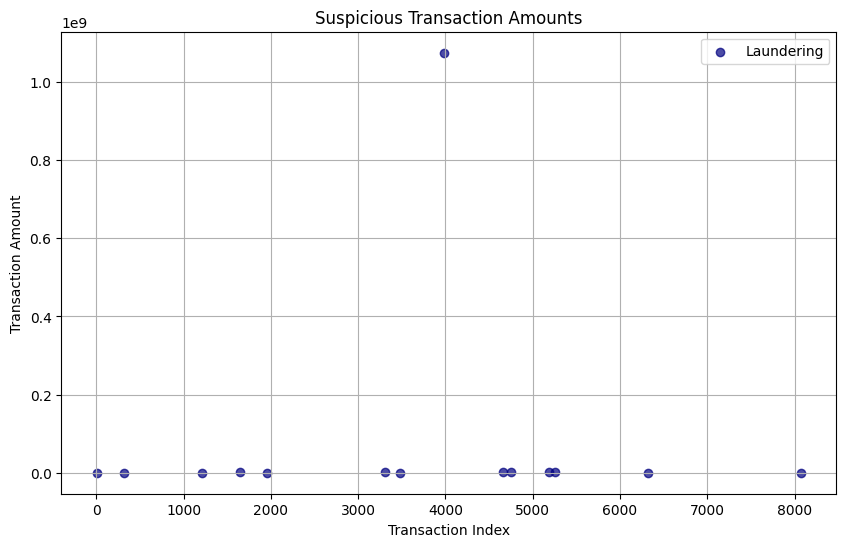

In [ ]:
laundering_data = df[df['Is_laundering'] == 1]
non_laundering_data = df[df['Is_laundering'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(laundering_data.index, laundering_data['Amount'], color='navy', label='Laundering', alpha=0.7)

plt.title('Suspicious Transaction Amounts')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.show()

**Trực quan hóa các giao dịch nghi ngờ rửa tiền**

Tách dữ liệu giao dịch thành hai nhóm: giao dịch nghi ngờ rửa tiền (laundering_data) và giao dịch không nghi ngờ rửa tiền (non_laundering_data).

Sau đó, Vẽ biểu đồ phân tán để hiển thị số tiền của các giao dịch nghi ngờ rửa tiền, với các điểm được đánh dấu và hiển thị theo chỉ mục giao dịch trên trục X và số tiền trên trục Y.


**Nhận Xét:**

Hầu hết các giao dịch đáng ngờ đều có số tiền khá thấp (gần trục x), với một ngoại lệ nổi bật có giá trị rất cao, gần 1 tỷ (1e9), tạo ra điểm dữ liệu ngoại lệ.

Phần lớn các điểm nằm ở mức rất thấp so với ngoại lệ này, cho thấy rằng các giao dịch đáng ngờ thường có số tiền nhỏ, trong khi một số ít giao dịch có thể có số tiền rất lớn.

Điểm dữ liệu cao nhất có thể là một dấu hiệu cảnh báo vì nó khác biệt hoàn toàn so với các giao dịch khác, gợi ý rằng đây có thể là một giao dịch đáng nghi cần kiểm tra kỹ hơn.

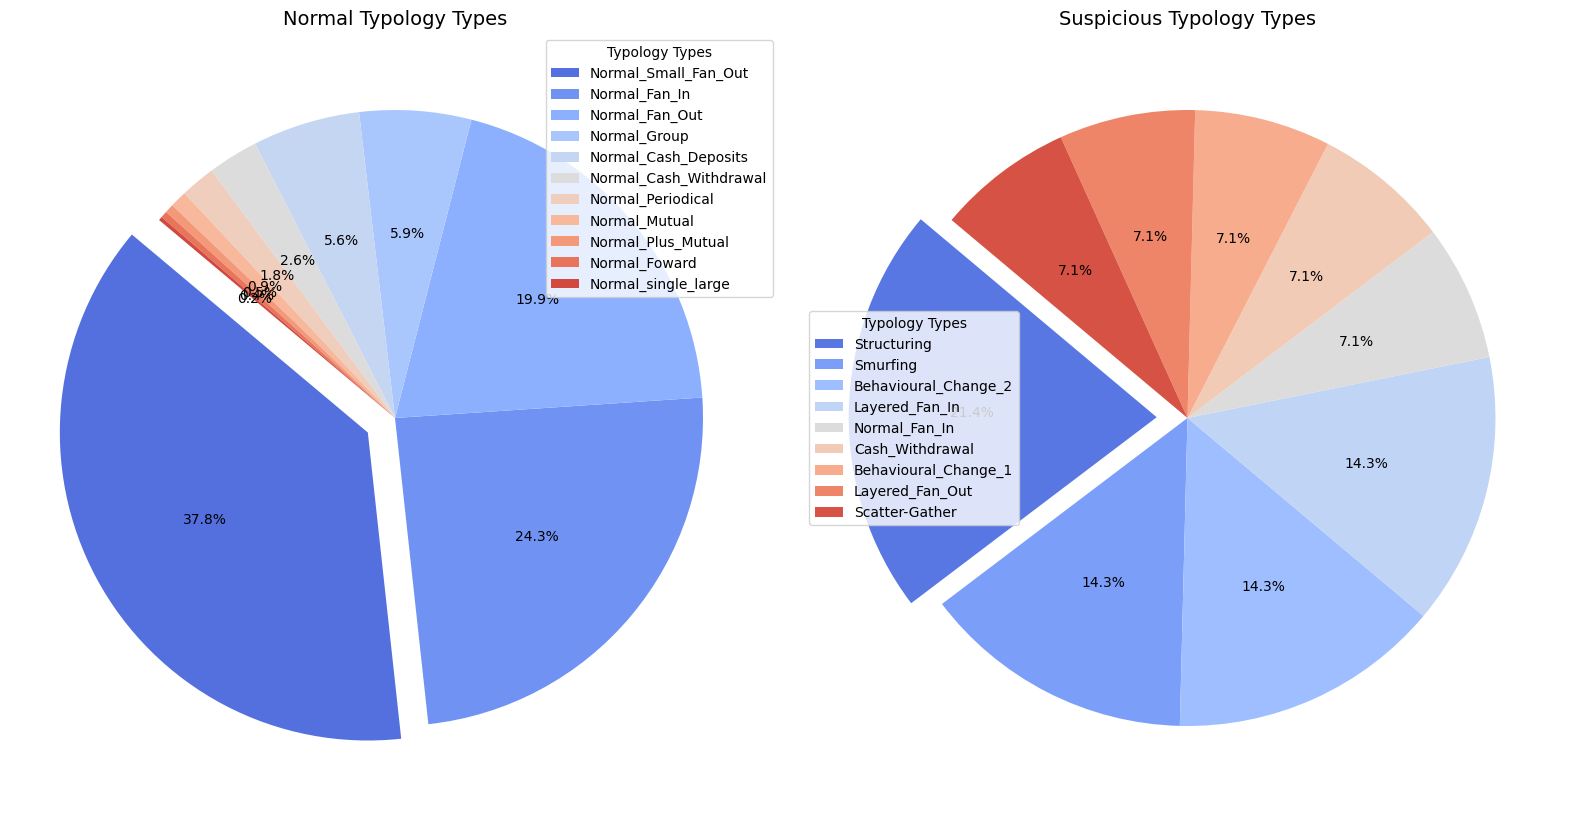

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')

combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot], how='outer')
combined_pivot = combined_pivot.fillna(0)

cm = sns.light_palette('CadetBlue', as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm)

combined_pivot['Laundering_Count'] = combined_pivot['Laundering_Count'].map(lambda x: '{:.2f}'.format(x))

normal_data = df[df['Is_laundering'] == 0]['Laundering_type'].value_counts()
laundering_data = df[df['Is_laundering'] == 1]['Laundering_type'].value_counts()

palette_normal = sns.color_palette("coolwarm", len(normal_data))
palette_laundering = sns.color_palette("coolwarm", len(laundering_data))

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
explode_normal = [0.1] + [0] * (len(normal_data) - 1)
patches, texts, autotexts = axs[0].pie(normal_data, explode=explode_normal, autopct='%1.1f%%', colors=palette_normal, startangle=140)
axs[0].set_title('Normal Typology Types', fontsize=14)
axs[0].legend(patches, normal_data.index, loc='best', title="Typology Types", fontsize=10)

explode_laundering = [0.1] + [0] * (len(laundering_data) - 1)
patches, texts, autotexts = axs[1].pie(laundering_data, explode=explode_laundering, autopct='%1.1f%%', colors=palette_laundering, startangle=140)
axs[1].set_title('Suspicious Typology Types', fontsize=14)
axs[1].legend(patches, laundering_data.index, loc='best', title="Typology Types", fontsize=10)

for text in texts + autotexts:
    text.set_fontsize(10)

plt.tight_layout()
plt.show()

**Phân tích và trực quan hóa dữ liệu giao dịch theo loại thanh toán và phân loại giao dịch.**

- Tạo bảng tổng hợp: Tính tổng số tiền và đếm số giao dịch bình thường, nghi ngờ rửa tiền theo loại thanh toán.
- Kết hợp bảng tổng hợp: Kết hợp các bảng và thay thế giá trị thiếu bằng 0.

- Tạo heatmap style: Áp dụng bảng màu để trực quan hóa bảng tổng hợp.

- Làm tròn giá trị: Làm tròn số lượng giao dịch nghi ngờ rửa tiền.

- Đếm loại giao dịch: Đếm số lượng giao dịch bình thường và nghi ngờ theo Laundering_type.
- Vẽ biểu đồ Pie: Hiển thị tỷ lệ các loại giao dịch bình thường và nghi ngờ rửa tiền.


**Nhận xét:**

Normal Typology Types: Các kiểu giao dịch bình thường có phân bố đa dạng, trong đó:

- Kiểu "Normal_Small_Fan_Out" chiếm tỷ lệ lớn nhất với 37.8%.

- Các kiểu phổ biến khác bao gồm "Normal_Fan_In" (24.3%) và
"Normal_Fan_Out" (19.9%).

- Các kiểu còn lại chiếm tỷ lệ thấp hơn, đặc biệt là "Normal_single_large" chỉ chiếm 0.2%.

Suspicious Typology Types: Các giao dịch đáng ngờ có sự phân bố đều hơn giữa các loại, với mỗi loại chiếm khoảng 7.1%, ngoại trừ "Structuring" chiếm 21.4% và "Smurfing", "Behavioural_Change_2", và "Layered_Fan_In" cùng chiếm khoảng 14.3%.

Nhìn chung, các giao dịch bình thường có một số kiểu chiếm tỷ lệ rất cao, trong khi các giao dịch đáng ngờ có sự phân bố đều hơn, tập trung vào các kiểu đặc thù hơn.


#**II. Data Pre-processing**

##**2.1. Encoding**

In [ ]:
def frequency_encoding(df, column):
    frequency_map = df[column].value_counts(normalize=True)
    df[column + '_freq_encoded'] = df[column].map(frequency_map)
    return df

columns_to_encode = ['Payment_currency', 'Received_currency',
                     'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Laundering_type']

for column in columns_to_encode:
    df = frequency_encoding(df, column)

df.drop(columns=columns_to_encode, inplace=True)
df

,Time,Date,Amount,Is_laundering,Payment_currency_freq_encoded,Received_currency_freq_encoded,Sender_bank_location_freq_encoded,Receiver_bank_location_freq_encoded,Payment_type_freq_encoded,Laundering_type_freq_encoded
0,2024-11-15 10:35:19,10/7/2022,145915.0,0,0.969803,0.906109,0.977802,0.915008,0.056594,0.056394
1,2024-11-15 10:35:20,10/7/2022,601964.0,0,0.969803,0.007599,0.977802,0.007199,0.104190,0.199180
2,2024-11-15 10:35:20,10/7/2022,541131.0,1,0.969803,0.906109,0.977802,0.915008,0.206879,0.243076
3,2024-11-15 10:35:20,10/7/2022,1432844.0,0,0.969803,0.906109,0.977802,0.915008,0.198880,0.377862
4,2024-11-15 10:35:21,10/7/2022,11895.0,0,0.969803,0.906109,0.977802,0.915008,0.204580,0.243076
...,...,...,...,...,...,...,...,...,...,...
9996,2024-11-15 16:54:44,10/7/2022,2459.0,0,0.969803,0.906109,0.977802,0.915008,0.056594,0.056394
9997,2024-11-15 16:54:44,10/7/2022,314778.0,0,0.969803,0.906109,0.977802,0.915008,0.198880,0.058494
9998,2024-11-15 16:54:47,10/7/2022,771524.0,0,0.969803,0.906109,0.977802,0.915008,0.202480,0.377862
9999,2024-11-15 16:54:52,10/7/2022,115737.0,0,0.969803,0.906109,0.977802,0.915008,0.202480,0.377862


**Mã hóa tần suất (frequency encoding) cho các cột trong DataFrame:**

- Sử dụng hàm frequency_encoding để tính tần suất xuất hiện của các giá trị trong cột và tạo cột mới với tần suất này.

- Mã hóa các cột ['Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Laundering_type'].

- Áp dụng hàm frequency_encoding cho từng cột trong danh sách.

- Loại bỏ cột gốc: Sau khi mã hóa, các cột gốc được loại bỏ.

Kết quả là các cột gốc được thay thế bằng các cột tần suất, giúp dữ liệu sẵn sàng cho mô hình học máy.

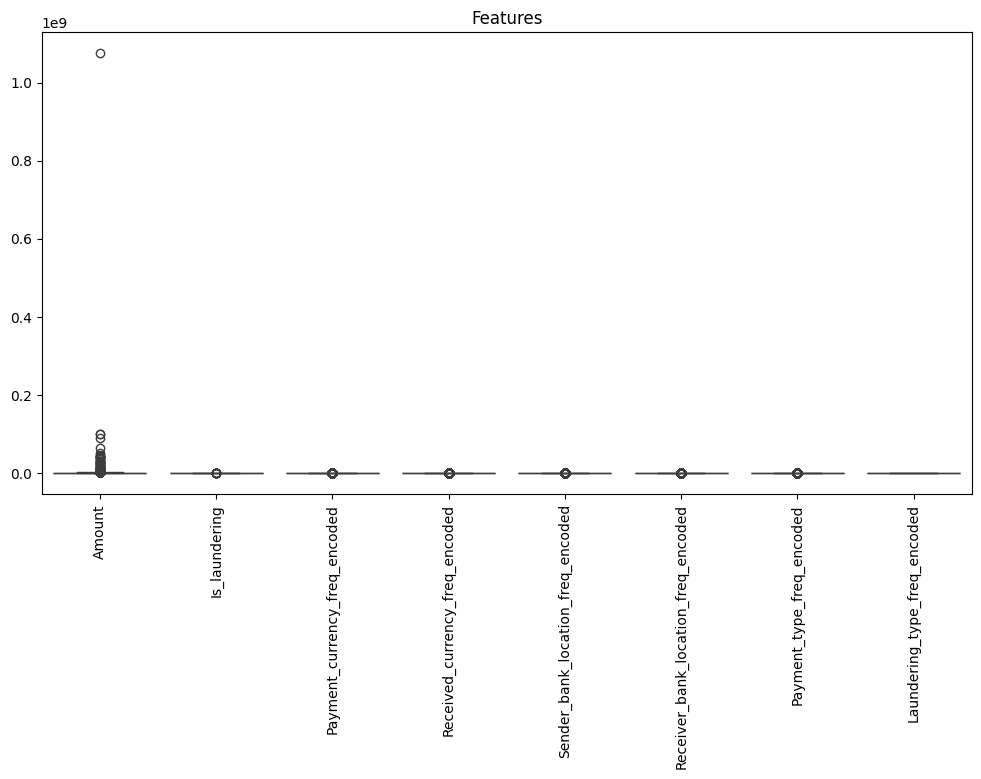

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title('Features')
plt.xticks(rotation=90)
plt.show()

**Kiểm tra sự phân bố của các giá trị trong các cột dữ liệu sau khi được mã hóa tần suất**

Vẽ biểu đồ hộp cho tất cả các cột, bao gồm cả các cột sau khi được mã hóa tần suất. Mục tiêu là phân tích sự phân bố và độ biến động của các tính năng (features) trong dữ liệu sau khi thực hiện mã hóa tần suất.

Biểu đồ cho thấy "Amount" là đặc trưng nổi bật, với một giá trị ngoại lệ rất cao, có thể liên quan đến rửa tiền. Các đặc trưng còn lại có giá trị thấp và ít biến động, chỉ đóng vai trò hỗ trợ trong phân tích.

##**2.2. Normalization**

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df.dtypes

,0
Time,datetime64[ns]
Date,datetime64[ns]
Amount,float64
Is_laundering,int64
Payment_currency_freq_encoded,float64
Received_currency_freq_encoded,float64
Sender_bank_location_freq_encoded,float64
Receiver_bank_location_freq_encoded,float64
Payment_type_freq_encoded,float64
Laundering_type_freq_encoded,float64


In [ ]:
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

df['Date_Year'] = pd.to_datetime(df['Date']).dt.year
df['Date_Month'] = pd.to_datetime(df['Date']).dt.month
df['Date_Day'] = pd.to_datetime(df['Date']).dt.day

df.drop(columns=['Time', 'Date'], inplace=True)
df

,Amount,Is_laundering,Payment_currency_freq_encoded,Received_currency_freq_encoded,Sender_bank_location_freq_encoded,Receiver_bank_location_freq_encoded,Payment_type_freq_encoded,Laundering_type_freq_encoded,Hour,Date_Year,Date_Month,Date_Day
0,145915.0,0,0.969803,0.906109,0.977802,0.915008,0.056594,0.056394,10,2022,10,7
1,601964.0,0,0.969803,0.007599,0.977802,0.007199,0.104190,0.199180,10,2022,10,7
2,541131.0,1,0.969803,0.906109,0.977802,0.915008,0.206879,0.243076,10,2022,10,7
3,1432844.0,0,0.969803,0.906109,0.977802,0.915008,0.198880,0.377862,10,2022,10,7
4,11895.0,0,0.969803,0.906109,0.977802,0.915008,0.204580,0.243076,10,2022,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2459.0,0,0.969803,0.906109,0.977802,0.915008,0.056594,0.056394,16,2022,10,7
9997,314778.0,0,0.969803,0.906109,0.977802,0.915008,0.198880,0.058494,16,2022,10,7
9998,771524.0,0,0.969803,0.906109,0.977802,0.915008,0.202480,0.377862,16,2022,10,7
9999,115737.0,0,0.969803,0.906109,0.977802,0.915008,0.202480,0.377862,16,2022,10,7


Tách các thành phần giờ, năm, tháng, và ngày từ các cột Time và Date trong DataFrame và lưu chúng vào các cột riêng biệt (Hour, Date_Year, Date_Month, Date_Day). Sau đó, các cột gốc Time và Date bị loại bỏ. Mục đích là làm cho dữ liệu dễ dàng hơn để phân tích các yếu tố thời gian.

In [ ]:
skewed_data = df['Amount']
original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

log_transformed_data = np.log1p(skewed_data)
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

df['Amount'] = log_transformed_data

Original Skewness: 92.76078849262875
Log-Transformed Skewness: -1.1541787136169532


**Tính toán và xử lý độ lệch (skewness) của cột Amount trong DataFrame**

- Tính độ lệch ban đầu của cột Amount để đánh giá mức độ không đối xứng của phân phối dữ liệu.

- Áp dụng biến đổi log để giảm độ lệch và làm cho phân phối gần hơn với phân phối chuẩn.

- Cập nhật cột Amount bằng dữ liệu sau khi biến đổi log để xử lý tốt hơn cho các mô hình học máy hoặc phân tích thống kê.

**Nhận xét:**

Ta thấy độ lệch ban đầu của cột Amount là: 92.76078849262875
Và độ lệch sau khi áp dụng biến đổi log là: -1.1541787136169532

##**2.3. Scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Amount', 'Hour']] = scaler.fit_transform(df[['Amount', 'Hour']])

> Vì cột 'Hour' và 'Amount' có giá trị lớn nên scale 2 cột này để tránh tác động không đồng đều lên mô hình

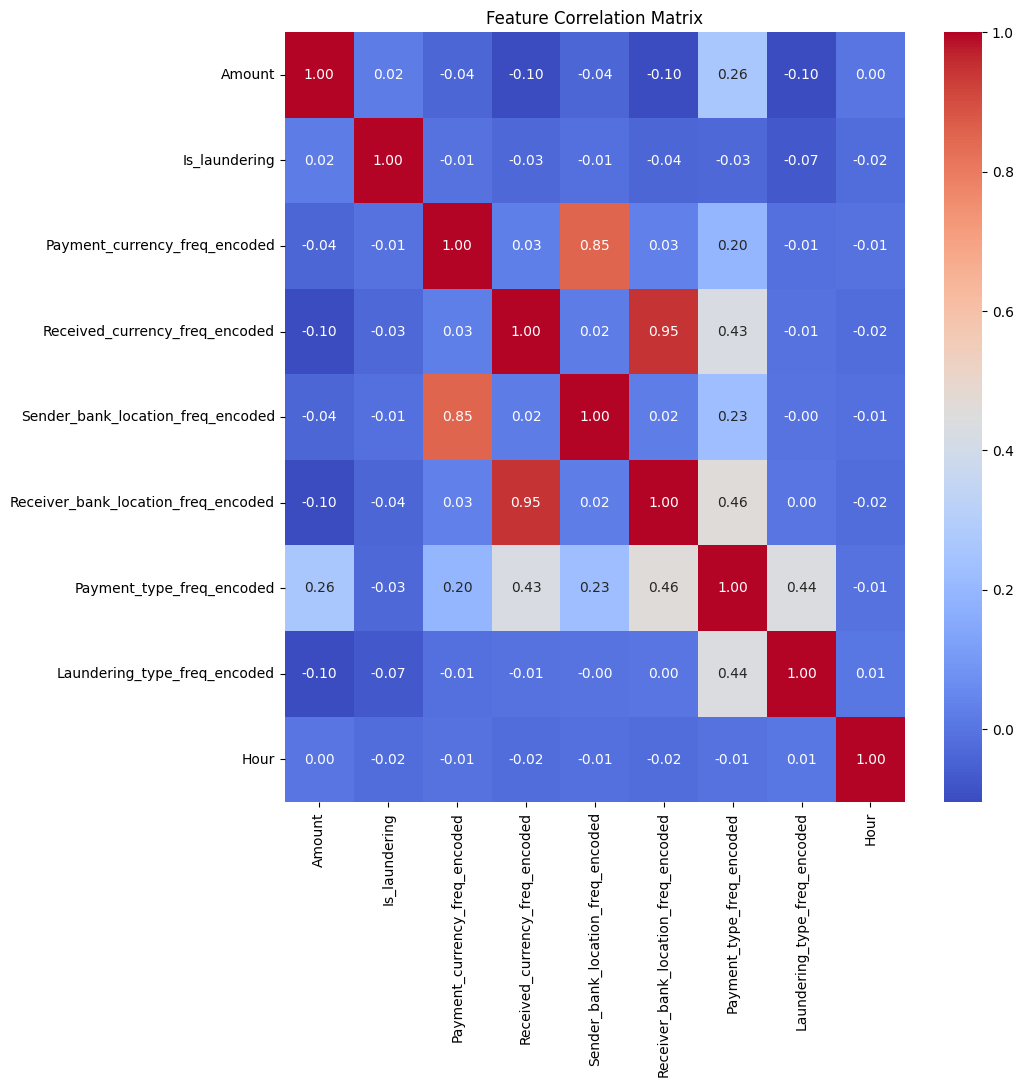

In [ ]:
df.drop(columns=['Date_Year',	'Date_Month',	'Date_Day'], inplace=True)
correlation_matrix = df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Feature Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

> Từ ma trận tương quan, có thể thấy các biến "Payment_currency" và "Sender_bank_location" có hệ số tương quan cao là 0,85 và tương tự, "Receiver_currency" và "Receiver_bank_location" cũng có hệ số tương quan là 0,95. Mối tương quan cao giữa "Payment_currency" và "Sender_bank_location" chủ yếu xuất phát từ thực tế là quốc gia của ngân hàng người gửi thường ảnh hưởng trực tiếp đến loại tiền tệ được sử dụng trong giao dịch và tương tự với người nhận. Nhóm em đã chọn xóa các biến "Sender_bank_location" và "Receiver_bank_location" để tránh ảnh hưởng đến kết quả của mô hình.

In [ ]:
df = df.drop([ 'Sender_bank_location_freq_encoded',
              'Receiver_bank_location_freq_encoded'],
             axis=1)
df

,Amount,Is_laundering,Payment_currency_freq_encoded,Received_currency_freq_encoded,Payment_type_freq_encoded,Laundering_type_freq_encoded,Hour
0,-0.593302,0,0.969803,0.906109,0.056594,0.056394,-1.737975
1,0.299957,0,0.969803,0.007599,0.104190,0.199180,-1.737975
2,0.232806,1,0.969803,0.906109,0.206879,0.243076,-1.737975
3,0.846576,0,0.969803,0.906109,0.198880,0.377862,-1.737975
4,-2.173390,0,0.969803,0.906109,0.204580,0.243076,-1.737975
...,...,...,...,...,...,...,...
9996,-3.166789,0,0.969803,0.906109,0.056594,0.056394,1.512117
9997,-0.108693,0,0.969803,0.906109,0.198880,0.058494,1.512117
9998,0.456382,0,0.969803,0.906109,0.202480,0.377862,1.512117
9999,-0.739347,0,0.969803,0.906109,0.202480,0.377862,1.512117


##**2.4. Splitting Data**

In [ ]:
X = df.drop('Is_laundering', axis=1)
y = df['Is_laundering']

> Data splitting với X là các biến đầu vào và y là biến đầu ra. Hay X chứa các đặc trưng (biến độc lập) để đưa vào mô hình dự đoán,
y chứa biến mục tiêu (biến phụ thuộc) mà mô hình cần dự đoán.







In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> Chia tập dữ liệu thành train và test
 với tỷ lệ ( train chiếm 80% và test 20%).

##**2.5. Class Balancing**

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
y = y_train_balanced
X = X_train_balanced

In [ ]:
class_counts = pd.Series(y_train_balanced).value_counts()
print("Số lượng lớp 0 sau khi cân bằng:", class_counts[0])
print("Số lượng lớp 1 sau khi cân bằng:", class_counts[1])

Số lượng lớp 0 sau khi cân bằng: 7990
Số lượng lớp 1 sau khi cân bằng: 7990


In [ ]:
X

,Amount,Payment_currency_freq_encoded,Received_currency_freq_encoded,Payment_type_freq_encoded,Laundering_type_freq_encoded,Hour
0,-0.350042,0.969803,0.906109,0.198880,0.377862,-1.196293
1,0.755635,0.969803,0.906109,0.202480,0.377862,-1.196293
2,0.435829,0.969803,0.010099,0.104190,0.243076,0.428753
3,-0.314078,0.969803,0.906109,0.202480,0.377862,0.428753
4,-1.824270,0.969803,0.906109,0.026397,0.026397,0.428753
...,...,...,...,...,...,...
15975,0.221078,0.969803,0.906109,0.199360,0.000213,0.898275
15976,0.719655,0.969803,0.906109,0.204214,0.000100,-0.112929
15977,0.274512,0.969803,0.906109,0.199151,0.000192,0.889055
15978,0.332315,0.969803,0.906109,0.200098,0.000185,0.805501


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
scaler = StandardScaler()
X_balanced_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_balanced_scaled, columns=X.columns)
X


,Amount,Payment_currency_freq_encoded,Received_currency_freq_encoded,Payment_type_freq_encoded,Laundering_type_freq_encoded,Hour
0,-0.588454,0.228156,0.536836,0.666001,1.648681,-1.318771
1,0.503522,0.228156,0.536836,0.733124,1.648681,-1.318771
2,0.187679,0.228156,-2.390487,-1.099702,0.738980,0.638881
3,-0.552936,0.228156,0.536836,0.733124,1.648681,0.638881
4,-2.044414,0.228156,0.536836,-2.550301,-0.723426,0.638881
...,...,...,...,...,...,...
15975,-0.024412,0.228156,0.536836,0.674943,-0.900148,1.204503
15976,0.467988,0.228156,0.536836,0.765467,-0.900913,-0.013670
15977,0.028361,0.228156,0.536836,0.671043,-0.900289,1.193396
15978,0.085447,0.228156,0.536836,0.688710,-0.900341,1.092741


> Chuẩn hoá X. Sau đó, dữ liệu đã chuẩn hóa được chuyển lại thành một dataframe để dễ dàng tiếp tục xử lý.

In [ ]:
feature_columns=X.columns
feature_columns

Index(['Amount', 'Payment_currency_freq_encoded',
       'Received_currency_freq_encoded', 'Payment_type_freq_encoded',
       'Laundering_type_freq_encoded', 'Hour'],
      dtype='object')

> Lưu trữ và tham chiếu các tên cột (features) của df X, giúp dễ dàng làm việc với các tên cột

#**III. Classification & Prediction**

##**3.1 Training Model + Evaluation with K-fold**

> Thêm khối trích dẫn



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd

models = [
    ('Logistic Regression', LogisticRegression()),
    ('SVM', SVC(kernel='linear', C=1.0)),
    ('Naive Bayes', GaussianNB()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Random Forest', RandomForestClassifier())
]

output = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models:
    model.fit(X, y)
    predictions = model.predict(X)
    accuracy_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    precision_scores = cross_val_score(model, X, y, cv=kf, scoring='precision')
    recall_scores = cross_val_score(model, X, y, cv=kf, scoring='recall')
    f1_scores = cross_val_score(model, X, y, cv=kf, scoring='f1')

    output['Model'].append(model_name)
    output['Accuracy'].append(np.mean(accuracy_scores))
    output['Precision'].append(np.mean(precision_scores))
    output['Recall'].append(np.mean(recall_scores))
    output['F1-score'].append(np.mean(f1_scores))

output_df = pd.DataFrame(output)
output_df


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.927472,0.913243,0.944941,0.928752
1,SVM,0.925845,0.917733,0.935808,0.926619
2,Naive Bayes,0.885544,0.859061,0.922672,0.889686
3,AdaBoost,0.999875,1.000000,0.999751,0.999875
4,Gradient Boosting,0.999875,0.999876,0.999875,0.999876
5,Random Forest,0.999812,0.999875,0.999750,0.999749


> Train model với việc áp dụng phương pháp K-Fold Cross Validation cho danh sách 6 mô hình phân loại khác nhau, bao gồm  Logistic Regression, SVM, Naive Bayes, AdaBoost, Gradient Boosting, Random Forest và tính các các chỉ số đánh giá  (Accuracy, Precision, Recall, F1-score)

##**3.2. Save Model**

In [ ]:
best_accuracy_index = output_df['Accuracy'].idxmax()
best_accuracy_models = output_df[output_df['Accuracy'] == output_df.loc[best_accuracy_index, 'Accuracy']]
best_model_name = best_accuracy_models.loc[best_accuracy_models['F1-score'].idxmax(), 'Model']
best_model_index = output_df.index[output_df['Model'] == best_model_name][0]
best_model = models[best_model_index][1]
best_model_save_path = '/content/drive/MyDrive/MyModel/BestModel.pkl'
os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)
joblib.dump(best_model, best_model_save_path)
print(f"Best model is: {best_model_name} with Accuracy: {output_df.loc[output_df['Model'] == best_model_name, 'Accuracy'].values[0]} and F1-Score: {output_df.loc[output_df['Model'] == best_model_name, 'F1-score'].values[0]}")
print(f"Best model saved at: {best_model_save_path}")


Best model is: Gradient Boosting with Accuracy: 0.9998748435544431 and F1-Score: 0.9998755057096208
Best model saved at: /content/drive/MyDrive/MyModel/BestModel.pkl


In [ ]:
scaler_save_path = '/content/drive/MyDrive/MyModel/Scaler.pkl'
os.makedirs(os.path.dirname(scaler_save_path), exist_ok=True)
joblib.dump(scaler, scaler_save_path)

['/content/drive/MyDrive/MyModel/Scaler.pkl']

> Lưu scaler vào google drive --> dễ dàng tải lại bộ chuẩn hóa này trong các lần chạy sau mà không cần huấn luyện lại.

##**3.3. Load Model**

In [ ]:
best_model = joblib.load(best_model_save_path)
best_model

GradientBoostingClassifier()

##**3.4. Prediction**

In [ ]:
from joblib import load
import pandas as pd
best_model = joblib.load(best_model_save_path)
scaler = joblib.load(scaler_save_path)
test_data = pd.DataFrame({
    'Amount': [100, 0.01],
    'Payment_currency_freq_encoded': [12,0.969],
    'Received_currency_freq_encoded': [19,0.5],
    'Payment_type_freq_encoded': [0.198693,-0.969],
    'Laundering_type_freq_encoded': [9,0.0001],
    'Hour': [0.966314, -0.12]
})
test_data[feature_columns] = scaler.transform(test_data[feature_columns])

predictions = best_model.predict(test_data)
print("Case 1: Predicted Is Laundering", predictions[0])
print("Case 2: Predicted Is Laundering", predictions[1])

Case 1: Predicted Is Laundering 0
Case 2: Predicted Is Laundering 1


> Load model đã được lưu và bộ chuẩn hoá từ file --> cho dữ liệu vào test --> predict giao dịch này có rửa tiền hay không

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier


def frequency_encoding(df, column):
    frequency_map = df[column].value_counts(normalize=True)
    df[column + '_freq_encoded'] = df[column].map(frequency_map)
    return df

instances_to_predict = pd.DataFrame({
    'Customer_ID': [710793783, 719756709],
    'Sender_account': [4253533793, 5479357050],
    'Receiver_account': [2248766608, 3456789401],
    'Amount': [17110.31, 4500.5],
    'Payment_currency': ['UK pounds','UK pounds'],
    'Received_currency': ['UK pounds', 'Dirham'],
    'Sender_bank_location': ['UK', 'UAE'],
    'Payment_type': ['Credit card', 'Cheque'],
    'Laundering_type': ['Normal_Fan_In', 'Normal_Fan_Out'],
    'Time': ['10:35:20 AM', '10:35:19 AM'],
    'Date': ['10/7/2022', '10/7/2022']
})

columns_to_encode = ['Payment_currency', 'Sender_bank_location', 'Laundering_type', 'Received_currency', 'Payment_type']

for column in columns_to_encode:
    instances_to_predict = frequency_encoding(instances_to_predict, column)

instances_to_predict['Date'] = pd.to_datetime(instances_to_predict['Date'])
instances_to_predict['Time'] = pd.to_datetime(instances_to_predict['Time'], errors='coerce')

instances_to_predict.drop(columns=columns_to_encode, inplace=True)

instances_to_predict.drop(columns=['Date', 'Time'], inplace=True)


scaler = StandardScaler()
instances_to_predict_scaled = scaler.fit_transform(instances_to_predict)

X_train = np.random.rand(10, instances_to_predict_scaled.shape[1])
y_train = np.random.randint(0, 2, 10)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

predictions = gb_model.predict(instances_to_predict_scaled)
print("Case 1: Predicted Is Laundering:", predictions[0])
print("Case 2: Predicted Is Laundering:", predictions[1])


<ipython-input-1-b0da56e39004>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  instances_to_predict['Time'] = pd.to_datetime(instances_to_predict['Time'], errors='coerce')


Case 1: Predicted Is Laundering: 1
Case 2: Predicted Is Laundering: 1
